In [1]:
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shutil
import os
import requests
import base64
from sklearn import metrics
from scipy.stats import zscore
import io
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import confusion_matrix
from sklearn import svm, datasets
from sklearn.metrics import accuracy_score
from mpl_toolkits.axes_grid1 import make_axes_locatable
from collections import Counter

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score
from itertools import cycle

# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)


# Encode text values to a single dummy variable.  The new columns (which do not replace the old) will have a 1
# at every location where the original column (name) matches each of the target_values.  One column is added for
# each target value.
def encode_text_single_dummy(df, name, target_values):
    for tv in target_values:
        l = list(df[name].astype(str))
        l = [1 if str(x) == str(tv) else 0 for x in l]
        name2 = "{}-{}".format(name, tv)
        df[name2] = l


# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)


# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column.  Is it really this hard? :(
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    #if target_type in (np.int64, np.int32):
        # Classification
    dummies = pd.get_dummies(df[target])
    return df[result].to_numpy().astype(np.float32), dummies.to_numpy().astype(np.float32)
    #else:
        # Regression
       # return df[result].to_numpy().astype(np.float32), df[target].to_numpy().astype(np.float32)

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)


# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)


# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
               * (normalized_high - normalized_low) + normalized_low
        
# This function submits an assignment.  You can submit an assignment as much as you like, only the final
# submission counts.  The paramaters are as follows:
# data - Pandas dataframe output.
# key - Your student key that was emailed to you.
# no - The assignment class number, should be 1 through 1.
# source_file - The full path to your Python or IPYNB file.  This must have "_class1" as part of its name.  
# .             The number must match your assignment number.  For example "_class2" for class assignment #2.
def submit(data,key,no,source_file=None):
    if source_file is None and '__file__' not in globals(): raise Exception('Must specify a filename when a Jupyter notebook.')
    if source_file is None: source_file = __file__
    suffix = '_class{}'.format(no)
    if suffix not in source_file: raise Exception('{} must be part of the filename.'.format(suffix))
    with open(source_file, "rb") as image_file:
        encoded_python = base64.b64encode(image_file.read()).decode('ascii')
    ext = os.path.splitext(source_file)[-1].lower()
    if ext not in ['.ipynb','.py']: raise Exception("Source file is {} must be .py or .ipynb".format(ext))
    r = requests.post("https://api.heatonresearch.com/assignment-submit",
        headers={'x-api-key':key}, json={'csv':base64.b64encode(data.to_csv(index=False).encode('ascii')).decode("ascii"),
        'assignment': no, 'ext':ext, 'py':encoded_python})
    if r.status_code == 200:
        print("Success: {}".format(r.text))
    else: print("Failure: {}".format(r.text))

ENCODING = 'utf-8'

def expand_categories(values):
    result = []
    s = values.value_counts()
    t = float(len(values))
    for v in s.index:
        result.append("{}:{}%".format(v,round(100*(s[v]/t),2)))
    return "[{}]".format(",".join(result))
        
def analyze(filename):
    print()
    print("Analyzing: {}".format(filename))
    df = pd.read_csv(filename,encoding=ENCODING,low_memory=False)
    cols = df.columns.values
    total = float(len(df))

    print("{} rows".format(int(total)))
    for col in cols:
        uniques = df[col].unique()
        unique_count = len(uniques)
        if unique_count>100:
            print("** {}:{} ({}%)".format(col,unique_count,int(((unique_count)/total)*100)))
        else:
            print("** {}:{}".format(col,expand_categories(df[col])))
            expand_categories(df[col])

def analyze_label(df):
    total = float(len(df))
    uniques = df['attack_cat'].unique()
    unique_count = len(uniques)
    print("** Label:{}".format(expand_categories(df['attack_cat'])))
                            
def plot_confusion_matrix(cm, names, title='Confusion matrix'):

    fig = plt.figure(figsize=(18, 18), dpi=55, )
    ax = fig.add_subplot(111)
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=90)
    plt.yticks(tick_marks, names)
    res = ax.imshow(np.array(cm), cmap=plt.cm.viridis,
                    interpolation='nearest')
    width, height = cm.shape

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.5)
    plt.colorbar(res, cax=cax)
    
def plot_roc(pred,y):
    fpr, tpr, _ = roc_curve(y, pred)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()
    
        
#Método para elegir un random_state adecuado
def random_state_search(df, y):
    for i in range(1000):
        x_train, x_test, y_train, y_test = train_test_split(
            x, y, test_size=0.25, random_state=i)

        expected_classes = np.argmax(y_test,axis=1)
        if len(Counter(expected_classes)) == y.shape[1]:
            random_state_val = i
            print(random_state_val)
            break
    return random_state_val

In [2]:
# Analyze UNSW-NB15_1

path = 'E:/Downloads/UNI/4/Otros/TFG/Datasets/UNSW-NB15/Datasets/UNSW-NB15_1.csv'
 
print(path)

df = pd.read_csv(path, header=None,low_memory=False)

df.columns = [
    'srcip',
    'sport',
    'dstip',
    'dsport',
    'proto',
    'state',
    'dur',
    'sbytes',
    'dbytes',
    'sttl',
    'dttl',
    'sloss',
    'dloss',
    'service',
    'Sload',
    'Dload',
    'Spkts',
    'Dpkts',
    'swin',
    'dwin',
    'stcpb',
    'dtcpb',
    'smeansz',
    'dmeansz',
    'trans_depth',
    'res_bdy_len',
    'Sjit',
    'Djit',
    'Stime',
    'Ltime',
    'Sintpkt',
    'Dintpkt',
    'tcprtt',
    'synack',
    'ackdat',
    'is_sm_ips_ports',
    'ct_state_ttl',
    'ct_flw_http_mthd',
    'is_ftp_login',
    'ct_ftp_cm',
    'ct_srv_src',
    'ct_srv_dst',
    'ct_dst_ltm',
    'ct_src_ ltm',
    'ct_src_dport_ltm',
    'ct_dst_sport_ltm',
    'ct_dst_src_ltm',
    'attack_cat',
    'label'
]

print("features nombradas-------------------------------")
print(len(df.columns))
display(df[0:5])

df['attack_cat'].fillna('Benign', inplace = True)

df.drop(columns=[
    'Stime',
    'Ltime',
    'Sintpkt',
    'Dintpkt',
    'label',], axis=1, inplace=True)

encode_text_dummy(df, 'srcip')
encode_text_index(df, 'sport')
encode_numeric_range(df, 'sport')
encode_text_dummy(df, 'dstip')
encode_text_index(df, 'dsport')
encode_numeric_range(df, 'dsport')
encode_text_dummy(df, 'proto')
encode_text_dummy(df, 'state')
encode_numeric_range(df, 'dur')
encode_numeric_range(df, 'sbytes')
encode_numeric_range(df, 'dbytes')
encode_numeric_range(df, 'sttl')
encode_numeric_range(df, 'dttl')
encode_numeric_range(df, 'sloss')
encode_numeric_range(df, 'dloss')
encode_text_dummy(df, 'service')
encode_numeric_range(df, 'Sload')
encode_numeric_range(df, 'Dload')
encode_numeric_range(df, 'Spkts')
encode_numeric_range(df, 'Dpkts')
encode_numeric_range(df, 'swin')
encode_numeric_range(df, 'dwin')
encode_numeric_range(df, 'stcpb')
encode_numeric_range(df, 'dtcpb')
encode_numeric_range(df, 'smeansz')
encode_numeric_range(df, 'dmeansz')
encode_numeric_range(df, 'trans_depth')
encode_numeric_range(df, 'res_bdy_len')
encode_numeric_range(df, 'Sjit')
encode_numeric_range(df, 'Djit')
encode_numeric_range(df, 'tcprtt')
encode_numeric_range(df, 'synack')
encode_numeric_range(df, 'ackdat')
encode_text_dummy(df, 'is_sm_ips_ports')
encode_numeric_range(df, 'ct_state_ttl')
encode_numeric_range(df, 'ct_flw_http_mthd')        
encode_text_dummy(df, 'is_ftp_login')
encode_numeric_range(df, 'ct_ftp_cm')
encode_numeric_range(df, 'ct_srv_src')
encode_numeric_range(df, 'ct_srv_dst')
encode_numeric_range(df, 'ct_dst_ltm')
encode_numeric_range(df, 'ct_src_ ltm')
encode_numeric_range(df, 'ct_src_dport_ltm')
encode_numeric_range(df, 'ct_dst_sport_ltm')
encode_numeric_range(df, 'ct_dst_src_ltm')    
                     
print("features finales-------------------------------")
print(len(df.columns))
display(df[0:5])

analyze_label(df)

#df.dropna(inplace=True,axis=1)

x, y = to_xy(df, 'attack_cat')

E:/Downloads/UNI/4/Otros/TFG/Datasets/UNSW-NB15/Datasets/UNSW-NB15_1.csv
features nombradas-------------------------------
49


,srcip,sport,dstip,dsport,proto,state,dur,sbytes,dbytes,sttl,...,ct_ftp_cm,ct_srv_src,ct_srv_dst,ct_dst_ltm,ct_src_ ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,attack_cat,label
0,59.166.0.0,1390,149.171.126.6,53,udp,CON,0.001055,132,164,31,...,0,3,7,1,3,1,1,1,NaN,0
1,59.166.0.0,33661,149.171.126.9,1024,udp,CON,0.036133,528,304,31,...,0,2,4,2,3,1,1,2,NaN,0
2,59.166.0.6,1464,149.171.126.7,53,udp,CON,0.001119,146,178,31,...,0,12,8,1,2,2,1,1,NaN,0
3,59.166.0.5,3593,149.171.126.5,53,udp,CON,0.001209,132,164,31,...,0,6,9,1,1,1,1,1,NaN,0
4,59.166.0.3,49664,149.171.126.0,53,udp,CON,0.001169,146,178,31,...,0,7,9,1,1,1,1,1,NaN,0


features finales-------------------------------
289


,sport,dsport,dur,sbytes,dbytes,sttl,dttl,sloss,dloss,Sload,...,service-pop3,service-radius,service-smtp,service-snmp,service-ssh,service-ssl,is_sm_ips_ports-0,is_sm_ips_ports-1,is_ftp_login-0,is_ftp_login-1
0,-0.867617,0.465743,-1.000000,-0.999981,-0.999978,-0.756863,-0.771654,-1.0,-1.0,-0.999810,...,0,0,0,0,0,0,1,0,1,0
1,-0.193740,-0.992318,-0.999992,-0.999923,-0.999959,-0.756863,-0.771654,-1.0,-1.0,-0.999967,...,0,0,0,0,0,0,1,0,1,0
2,-0.842361,0.465743,-1.000000,-0.999979,-0.999976,-0.756863,-0.771654,-1.0,-1.0,-0.999802,...,0,0,0,0,0,0,1,0,1,0
3,-0.116424,0.465743,-1.000000,-0.999981,-0.999978,-0.756863,-0.771654,-1.0,-1.0,-0.999834,...,0,0,0,0,0,0,1,0,1,0
4,0.351813,0.465743,-1.000000,-0.999979,-0.999976,-0.756863,-0.771654,-1.0,-1.0,-0.999810,...,0,0,0,0,0,0,1,0,1,0


** Label:[Benign:96.83%,Generic:1.07%,Exploits:0.77%, Fuzzers:0.72%,Reconnaissance:0.25%,DoS:0.17%,Backdoors:0.08%,Analysis:0.08%,Shellcode:0.03%,Worms:0.0%]


In [3]:
#Find the correct random state value
random_state_val = random_state_search(df, y)
print("Seed: {}".format(random_state_val))

# Create a test/train split.  25% test
# Split into train/test
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.25, random_state=random_state_val)

print("Inicio----------------------------------------------------------------------------------------------------------------------------------------------m01_R3_G1__sigmoid ")

model6 = Sequential()

model6.add(Dense(43, input_dim=x.shape[1], kernel_initializer='normal', activation='sigmoid'))
model6.add(Dense(22, input_dim=x.shape[1], kernel_initializer='normal', activation='sigmoid'))
model6.add(Dense(10, input_dim=x.shape[1], kernel_initializer='normal', activation='sigmoid'))
model6.add(Dense(1, kernel_initializer='normal'))
model6.add(Dense(y.shape[1],activation='softmax'))
model6.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
model6.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor],verbose=1,epochs=1000)

# Measure accuracy
pred = model6.predict(x_test)
pred = np.argmax(pred,axis=1)
y_eval = np.argmax(y_test,axis=1)
score = metrics.accuracy_score(y_eval, pred)
print("Validation score: {}".format(score))
model6.summary()


0
Seed: 0
Inicio----------------------------------------------------------------------------------------------------------------------------------------------m01_R3_G1__sigmoid 
Train on 525000 samples, validate on 175001 samples
Epoch 1/1000
525000/525000 [==============================] - 27s 52us/sample - loss: 0.1041 - accuracy: 0.9737 - val_loss: 0.0482 - val_accuracy: 0.9836
Epoch 2/1000
525000/525000 [==============================] - 25s 47us/sample - loss: 0.0431 - accuracy: 0.9855 - val_loss: 0.0436 - val_accuracy: 0.9852
Epoch 3/1000
525000/525000 [==============================] - 25s 48us/sample - loss: 0.0402 - accuracy: 0.9861 - val_loss: 0.0407 - val_accuracy: 0.9857
Epoch 4/1000
525000/525000 [==============================] - 25s 48us/sample - loss: 0.0388 - accuracy: 0.9864 - val_loss: 0.0394 - val_accuracy: 0.9859
Epoch 5/1000
525000/525000 [==============================] - 25s 48us/sample - loss: 0.0381 - accuracy: 0.9866 - val_loss: 0.0391 - val_accuracy: 0.9866


{'name': 'sequential',
 'layers': [{'class_name': 'Dense',
   'config': {'name': 'dense',
    'trainable': True,
    'batch_input_shape': (None, 288),
    'dtype': 'float32',
    'units': 43,
    'activation': 'sigmoid',
    'use_bias': True,
    'kernel_initializer': {'class_name': 'RandomNormal',
     'config': {'mean': 0.0, 'stddev': 0.05, 'seed': None}},
    'bias_initializer': {'class_name': 'Zeros', 'config': {}},
    'kernel_regularizer': None,
    'bias_regularizer': None,
    'activity_regularizer': None,
    'kernel_constraint': None,
    'bias_constraint': None}},
  {'class_name': 'Dense',
   'config': {'name': 'dense_1',
    'trainable': True,
    'batch_input_shape': (None, 288),
    'dtype': 'float32',
    'units': 22,
    'activation': 'sigmoid',
    'use_bias': True,
    'kernel_initializer': {'class_name': 'RandomNormal',
     'config': {'mean': 0.0, 'stddev': 0.05, 'seed': None}},
    'bias_initializer': {'class_name': 'Zeros', 'config': {}},
    'kernel_regularizer':

Accuracy: 0.9868229324403861
Normalized confusion matrix


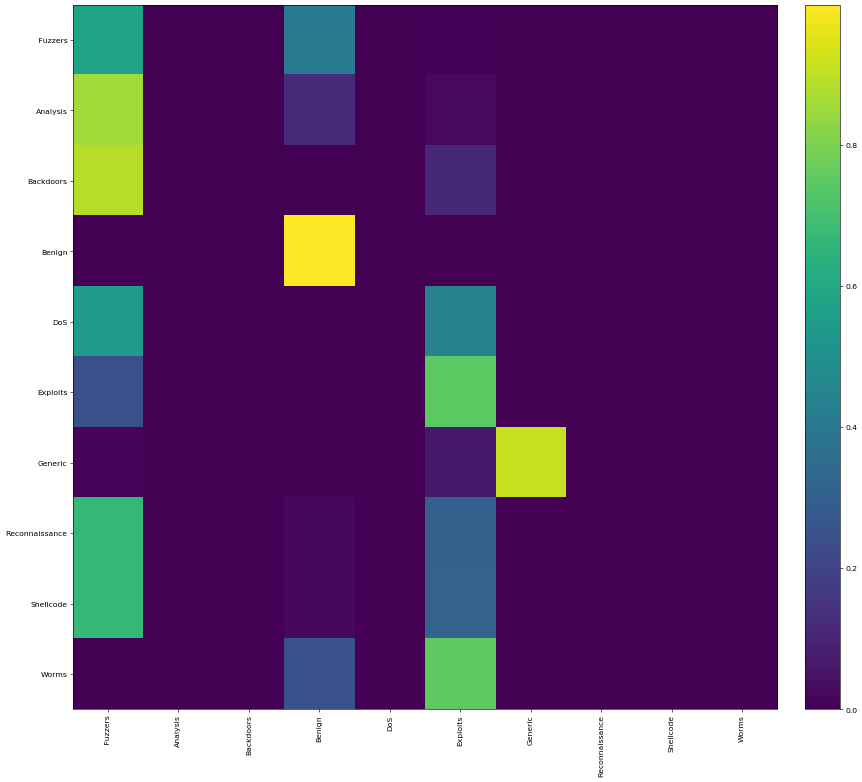

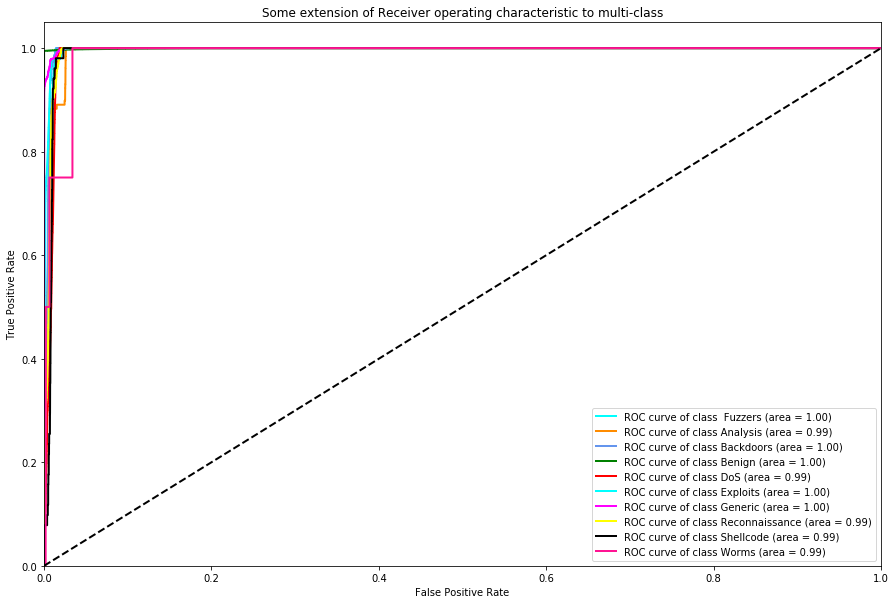

Counter({3: 169396,
         0: 1288,
         6: 1870,
         2: 146,
         5: 1391,
         4: 292,
         1: 128,
         7: 435,
         8: 51,
         9: 4})

Fin----------------------------------------------------------------------------------------------------------------------------------------------m01_R3_G1__sigmoid 
10
4


Counter({3: 169782, 0: 2029, 6: 1706, 5: 1484})

In [5]:
#Accuracy
pred = model6.predict(x_test)
predict_classes = np.argmax(pred,axis=1)
expected_classes = np.argmax(y_test,axis=1)
correct = accuracy_score(expected_classes,predict_classes)
print(f"Accuracy: {correct}")

#Confusion Matrix
dummies = pd.get_dummies(df['attack_cat']) # Classification
species = dummies.columns

pred = model6.predict(x_test)
pred = np.argmax(pred, axis=1)
y_test2 = np.argmax(y_test, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_test2, pred)
np.set_printoptions(precision=2)

# Normalize the confusion matrix by row (i.e by the number of samples
# in each class)
print("Normalized confusion matrix")
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plot_confusion_matrix(cm_normalized, species, title='Normalized confusion matrix')

plt.show()

#ROC
pred = model6.predict(x_test)
n_classes = y.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
lw = 2
plt.figure(figsize=(15,10))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black', 'deeppink', 'navy'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(species[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

print("Fin----------------------------------------------------------------------------------------------------------------------------------------------m01_R3_G1__sigmoid ")

print(len(Counter(expected_classes)))
display(Counter(expected_classes))
print(len(Counter(predict_classes)))
display(Counter(predict_classes))


Confusion matrix, without normalization


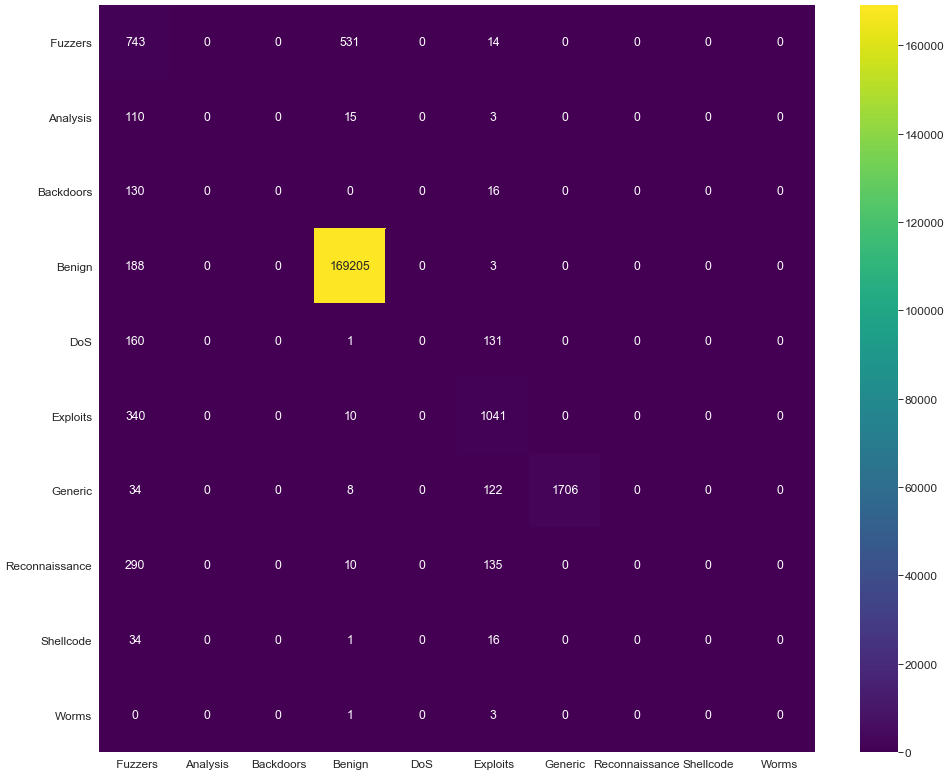

In [7]:
import seaborn as sn

print('Confusion matrix, without normalization')

fig = plt.figure(figsize=(21, 18), dpi=55, )
    
sn.set(font_scale=1.4) # for label size
sn.heatmap(cm, annot=True, annot_kws={"size": 16}, fmt="d", xticklabels=species, yticklabels=species, cmap=plt.cm.viridis) # font size


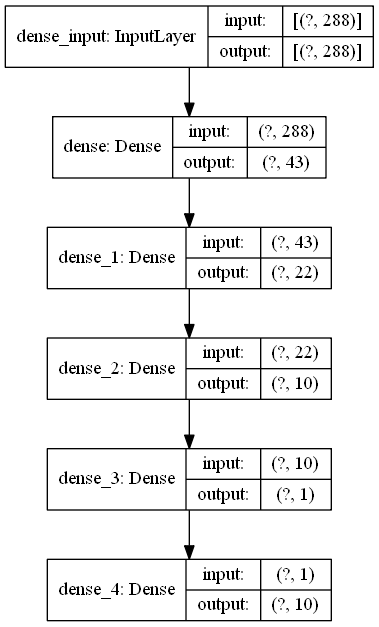

In [8]:
from tensorflow.keras.utils import plot_model

plot_model(model6, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [9]:
###DONE###